<a href="https://colab.research.google.com/github/FrankGangWang/AppliedML_Python_Coursera/blob/master/Copy_of_Copy_of_Interview_for_DataScience_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Interview questions to test data science skills**

---




# Let's load the data from public GitHub account

In [2]:
import pandas as pd
import numpy as np

In [53]:
df = pd.read_pickle("https://github.com/manjiler/interview_for_datascience/raw/master/interview_storage.pkl")

In [4]:
df.head(5)

,systemId,timestamp,model_type,cpu_utilization,read_cache_miss,write_cache_miss,read_iops,write_iops,read_throughput,write_throughput,read_iosz,write_iosz
0,sys1,1.572807e+12,A,18.701342,24.334389,71.529175,12990.702148,13171.539062,502967.31250,359029.093750,38.720345,27.258642
1,sys2,1.572812e+12,A,10.630484,11.163696,64.186844,34157.523438,25964.236328,482210.59375,537779.562500,14.117196,20.712614
2,sys3,1.572812e+12,B,5.637269,7.230949,62.729401,11787.345703,5525.521484,394009.28125,172450.578125,33.425911,31.209654
3,sys4,1.572813e+12,A,3.380666,13.382729,56.605385,28032.042969,14931.455078,412009.06250,205794.531250,14.697840,13.782779
4,sys5,1.572817e+12,A,2.641213,17.485886,69.983536,22266.902344,7150.452148,658391.06250,225116.828125,29.568398,31.482992


In [ ]:
# check missing data
df.info()

In [ ]:
df.describe().T


In [ ]:
(df_stat['max']/df_stat['75%'])


## Now that the data is loaded. let's begin!!!

# **About the data**

---
This is time series data for one month collected for N number of devices

Columns

systemId - Device name

timestamp - epoch time when the sensor data was collected

model_type - Different versions/release/model of the device (similar to mobile models)

cpu_utilization - this percentage of how much the CPU is used on the device.

read_cache_miss - Percentage of read that were not present in the Cache

write_cache_miss - Percentage of write that were not present in the Cache

read_iops -  Number of read IOs per second (Input/Output)

write_iops -  Nummber of write IOs per second (Input/Output)

read_throughput - the read bandwidth per second (Units kbps)

write_throughput - the write bandwidth per second (Units kbps)

read_iosz - the block size for read Input/Output operations

write_iosz - the block size for write Input/Output operations


y -> cpu_utilization



In [ ]:
print(f" df.shape={df.shape},\n df.columns={df.columns}")
sysIDs = np.unique(df['systemId'])
print(f" sysIDs shape={sysIDs.shape},\n sysIDs={sysIDs}")
model_types = np.unique(df['model_type'])
print(f" model_types shape={model_types.shape}, model_types ={model_types}")

## Q1. Do an EDA on the data, correlation plots, features that might be important for the modeling. Share your observations. Comment on how the data looks from modeling perspective

In [54]:
# convert epoch in ms to datetime; 
# add sin/cos day, hour
import datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', origin='unix')
date_time = df['timestamp']
timestamp_s = date_time.map(datetime.datetime.timestamp)
hour = 60*60
day = 24*hour

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / hour))
df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / hour))

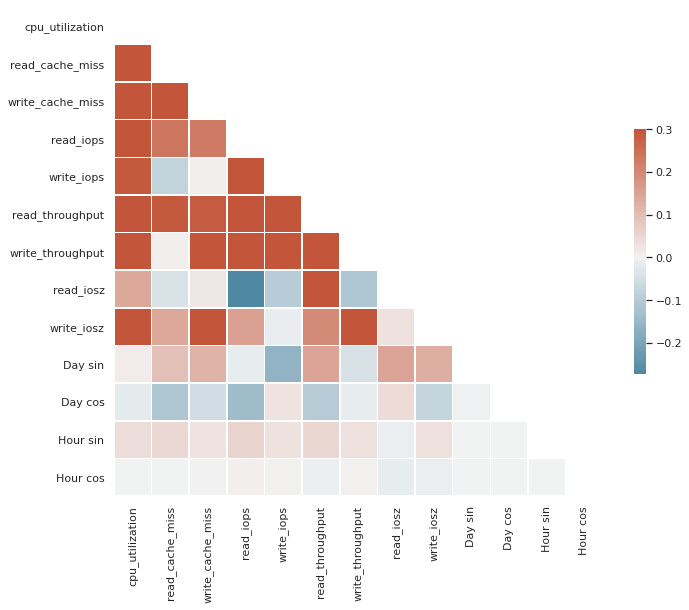

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Q2. Group on systemId and one week's duration and then calculate following custom metrics
- std/median on columns read_iops, read_cache_miss
- rolling mean on columns write_throughput and write_iosz
- exponential moving average on column write_cache_miss and write_iops


In [ ]:
df.set_index(df.pop('timestamp'), inplace=True)
df.head()

In [60]:
features = ['read_iops', 'read_cache_miss']
dftemp = df[['systemId', 'read_iops', 'read_cache_miss']]
df_grouped = dftemp.groupby('systemId')

ct = 0
for group_name, df_group in df_grouped:
  ct = ct + 1
  if ct>1: 
    break
  df_group = df_group.sort_values(by='timestamp')
  print(f'\n\n ****** {group_name} , shape={df_group.shape}****') 
  print(df_group[features].head())

  stat = df_group.resample('W', origin='start').sum()
  print(f'\n ****** {group_name} sum, shape={stat.shape}****') 
  print(stat[features])

  stat = df_group.resample('W', origin='start').median()
  print(f'\n ****** {group_name} median, shape={stat.shape}****') 
  print(stat[features])
  
  
  stat = df_group.resample('W', origin='start').std()
  print(f'\n ****** {group_name} std, shape={stat.shape}****') 
  print(stat[features])





 ****** sys1 , shape=(7926, 3)****
                        read_iops  read_cache_miss
timestamp                                         
2019-11-01 04:25:00  28376.779297        29.517067
2019-11-01 04:30:00  23255.777344        22.776077
2019-11-01 04:35:00  29459.712891        24.555496
2019-11-01 04:40:00  31246.083984        34.285210
2019-11-01 04:45:00  29159.644531        33.103394

 ****** sys1 sum, shape=(5, 2)****
               read_iops  read_cache_miss
timestamp                                
2019-11-03  2.158005e+07     32920.263950
2019-11-10  5.303513e+07     91807.088024
2019-11-17  4.576531e+07     78825.010387
2019-11-24  5.389625e+07     81546.858440
2019-12-01  3.712149e+07     51383.192360

 ****** sys1 median, shape=(5, 2)****
               read_iops  read_cache_miss
timestamp                                
2019-11-03  25839.449219        39.243538
2019-11-10  25875.551758        45.927494
2019-11-17  25047.837891        44.240940
2019-11-24  26970.410156   

In [ ]:
# 1. get one systemId's data; 
# 2. sort by timestamp 
df1_sysId = df1[df1['systemId']=='sys1']
del df1_sysId['systemId']
df1_sysId = df1_sysId.sort_values(by='timestamp')
df1_sysId.head()

In [ ]:
print(f" time min={df['timestamp'].min()}, \n time max={df['timestamp'].max()}")
print(df.head(3))
print(df.tail(3))
t_week = datetime.timedelta(weeks=1)
t_start = df['timestamp'].min()
t_stop = t_start + t_week
df1 = df[(df['timestamp'] > t_start) & (df['timestamp'] <= t_stop )]
print(f"t_start={t_start}, t_stop={t_stop}")
print(f" time min={df1['timestamp'].min()}, \n time max={df1['timestamp'].max()}")
print(f"df shape={df.shape}, df1 shape={df1.shape}")

In [60]:
#normalization
# defiine columns_to_scale
from sklearn.preprocessing import StandardScaler
columns_to_scale = list(df1_sysId.columns)
columns_to_scale.remove('timestamp')
columns_to_scale.remove('model_type')
print(f"columns_to_scale={columns_to_scale}")
autoscaler = StandardScaler()
df1_sysId[columns_to_scale] = autoscaler.fit_transform(df1_sysId[columns_to_scale])

columns_to_scale=['cpu_utilization', 'read_cache_miss', 'write_cache_miss', 'read_iops', 'write_iops', 'read_throughput', 'write_throughput', 'read_iosz', 'write_iosz']


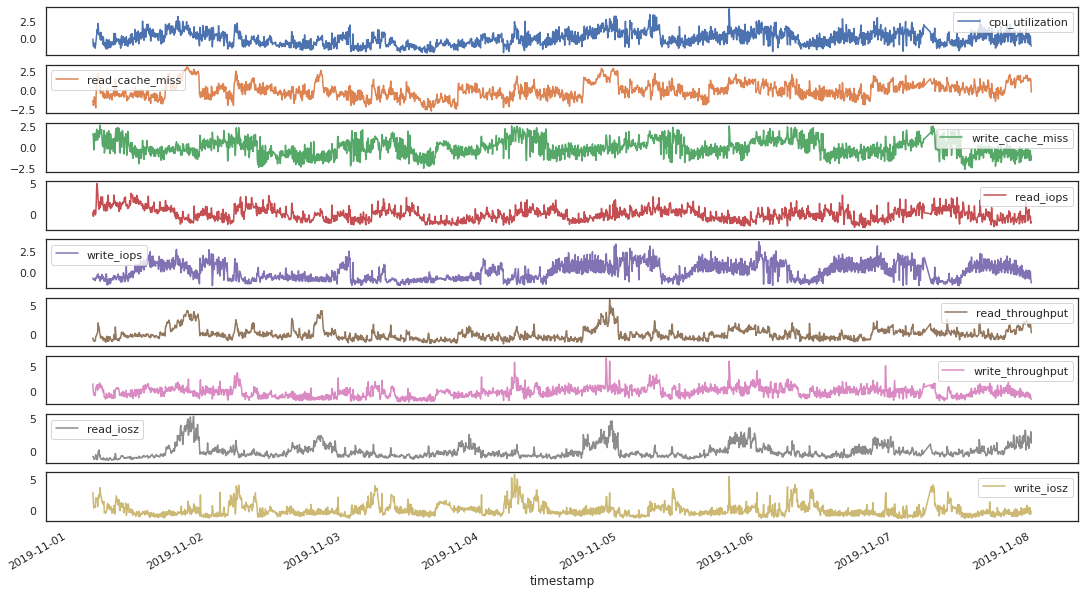

In [61]:
plot_features = df1_sysId[columns_to_scale]
plot_features.index = df1_sysId['timestamp']
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


In [ ]:
# sample period is 5 min
sample_period = 5
plot_len = int(24*60/5)
plot_features = df[columns_to_scale][:plot_len]
plot_features.index = df1_sysId['timestamp'][:plot_len]
_ = plot_features.plot(subplots=True)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

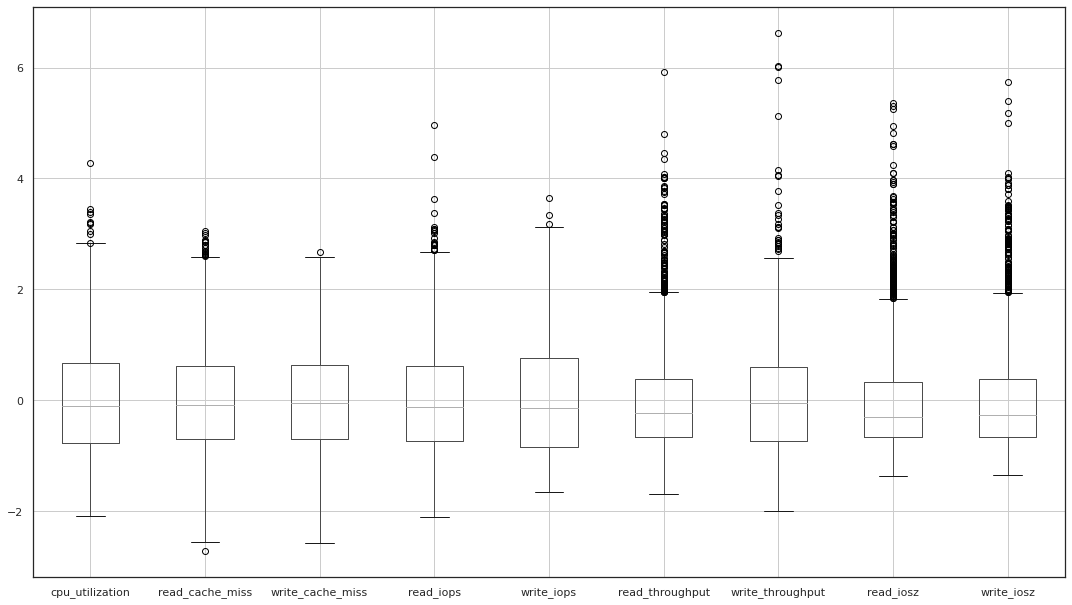

In [63]:

boxplot = df1_sysId.boxplot(column=columns_to_scale)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)


Text(0.5, 1.0, 'Time of day signal')

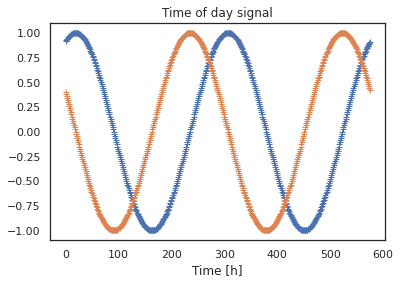

In [73]:
sample_period = 5
plot_len = int(2*24*60/5) # plot 2 day

plt.plot(np.array(df1_sysId['Day sin'])[:plot_len], '+')
plt.plot(np.array(df1_sysId['Day cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of Year signal')

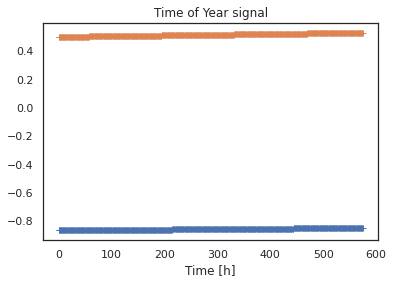

In [74]:
plt.plot(np.array(df1_sysId['Year sin'])[:plot_len], '+')
plt.plot(np.array(df1_sysId['Year cos'])[:plot_len], '+')
plt.xlabel('Time [h]')
plt.title('Time of Year signal')

In [75]:
df1_sysId.describe().T


,count,mean,std,min,25%,50%,75%,max
cpu_utilization,1952.0,-3.890331e-17,1.000256,-2.088536,-0.770918,-0.104653,0.671069,4.275441
read_cache_miss,1952.0,-1.311423e-16,1.000256,-2.726930,-0.698705,-0.094416,0.621408,3.051646
write_cache_miss,1952.0,1.573195e-16,1.000256,-2.577265,-0.696552,-0.044753,0.630073,2.665782
read_iops,1952.0,1.899664e-17,1.000256,-2.100068,-0.734433,-0.116606,0.626800,4.958413
write_iops,1952.0,1.162549e-16,1.000256,-1.653998,-0.850587,-0.138065,0.757738,3.643233
read_throughput,1952.0,1.685241e-16,1.000256,-1.690705,-0.671588,-0.229665,0.376630,5.912620
write_throughput,1952.0,-2.814233e-16,1.000256,-2.001948,-0.737455,-0.050972,0.604645,6.631765
read_iosz,1952.0,-2.015692e-16,1.000256,-1.363266,-0.660542,-0.298023,0.337359,5.358109
write_iosz,1952.0,-2.207649e-16,1.000256,-1.355002,-0.670759,-0.263300,0.377392,5.734200
Day sin,1952.0,-1.991646e-02,0.707894,-1.000000,-0.722364,-0.043619,0.691513,1.000000


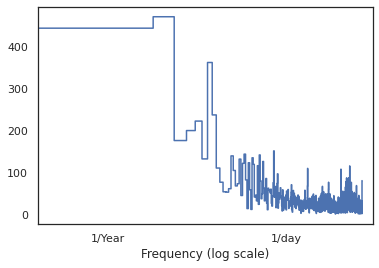

In [78]:
# fft plot
import tensorflow as tf
fft = tf.signal.rfft(df1_sysId['cpu_utilization'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df1_sysId['cpu_utilization'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
#plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')


In [6]:
cols_std =  ['read_iops', 'read_cache_miss']
cols_rolling_mean = ['write_throughput', 'write_iosz']
cols_exp_mvavg = ['write_cache_miss', 'write_iops']

group_by_systemId = df1.groupby("systemId") #, axis="columns"
group = group_by_systemId.get_group('sys1')
group = group[['timestamp', 'write_throughput', 'write_iosz']]

print(f'len ={len(group)}')
group.head(8)



len =1952


,timestamp,write_throughput,write_iosz
0,2019-11-03 18:45:00,359029.093750,27.258642
24,2019-11-04 11:10:00,391059.843750,33.317554
49,2019-11-05 06:30:00,644081.062500,27.810186
76,2019-11-05 22:55:00,588804.312500,22.281116
103,2019-11-06 14:25:00,593935.125000,18.569221
113,2019-11-06 19:15:00,539323.062500,24.459118
127,2019-11-07 08:50:00,206256.484375,19.043331
743,2019-11-05 10:45:00,377669.687500,20.309162


In [ ]:
group = group.sort_values(by='timestamp')
group.head(8)

,timestamp,write_throughput,write_iosz
39319,2019-11-01 04:25:00,643395.06250,44.144405
168399,2019-11-01 04:30:00,452817.37500,33.769337
19678,2019-11-01 04:35:00,354100.65625,26.051140
172625,2019-11-01 04:40:00,402049.09375,28.529280
171162,2019-11-01 04:45:00,375960.68750,28.852577
157734,2019-11-01 04:50:00,336585.21875,26.842281
155093,2019-11-01 04:55:00,519666.68750,37.744625
172252,2019-11-01 05:00:00,568910.81250,37.253868


In [ ]:
tmp = group.rolling(2).mean()
tmp.head(8)

,write_throughput,write_iosz,rmean_write_throughput,rmean_write_iosz
39319,NaN,NaN,NaN,NaN
168399,548106.218750,38.956871,NaN,NaN
19678,403459.015625,29.910238,475782.617188,34.433555
172625,378074.875000,27.290210,390766.945312,28.600224
171162,389004.890625,28.690928,383539.882812,27.990569
157734,356272.953125,27.847429,372638.921875,28.269179
155093,428125.953125,32.293453,392199.453125,30.070441
172252,544288.750000,37.499247,486207.351562,34.896350


In [ ]:
group['rmean_write_throughput'] = tmp['write_throughput']
group['rmean_write_iosz'] = tmp['write_iosz']
group.head(8)

,timestamp,write_throughput,write_iosz,rmean_write_throughput,rmean_write_iosz
39319,2019-11-01 04:25:00,643395.06250,44.144405,NaN,NaN
168399,2019-11-01 04:30:00,452817.37500,33.769337,548106.218750,38.956871
19678,2019-11-01 04:35:00,354100.65625,26.051140,403459.015625,29.910238
172625,2019-11-01 04:40:00,402049.09375,28.529280,378074.875000,27.290210
171162,2019-11-01 04:45:00,375960.68750,28.852577,389004.890625,28.690928
157734,2019-11-01 04:50:00,336585.21875,26.842281,356272.953125,27.847429
155093,2019-11-01 04:55:00,519666.68750,37.744625,428125.953125,32.293453
172252,2019-11-01 05:00:00,568910.81250,37.253868,544288.750000,37.499247


In [ ]:

if 0:
  summary = []
  for name, group in group_by_systemId:
    summary.append(
      {
        name : 
          {
            'length': len(group),
            'min': group['read_iops'].min(),
            'max': group['read_iops'].max(),
            'mean': group['read_iops'].mean(),
            'std': group['read_iops'].std(),
            'median': group['read_iops'].median()
          }
      }
    )
  if 0:
    print(f'name={name}, len = {len(group)}\n')
    print('systemId uniques=', np.unique(group['systemId']))
    #print(f'group={group.head(2)}\n')
    print(f'summary={summary}')


## Q3. Generate a random distribution of samples from data such that each day should contain 12 continous samples and start of the sample should be random with that day

## Q4. Fit a linear regression to this data with y as "cpu_utilization" column. Comment on the fit of the model

## Q5. Create a column where cpu_utilization < 20 is 0 and cpu_utilization >= 20 as 1. Using this newly created column build a logistic regression. Commment on the evaluation of the model.

## Q6. Fit a simple decision tree regressor to this data. Comment about the fit of the model

## Q7. Fit a Random forest regressor. Compare this with simple dicision tree. If Random forest is better then why

## Q8. How do improve the accuracy of Random forest regressor

## Q9. Cluster the input variables using KMeans and GMM.
       
1.   Draw the contour plots
2.   Explain the hyper-parameters you choose and why?

